In [1]:
# %load inference_4_beams.py
#!/usr/bin/env python

# In[1]:


import numpy as np;
import torch as T;
import copy ;
import time;
import matplotlib.pyplot as plt;
import scipy.optimize
import os;

import Pyccat;
from Pyccat import field_calculation;
from Pyccat import Make_fitfuc;
from Pyccat import Model;

import Kirchhoffpy;
from Kirchhoffpy.Spheical_field import spheical_grid;
from Kirchhoffpy.coordinate_operations import Coord;
from Kirchhoffpy.inference import correctphase;
from fitting_error_plot import error_plots

DEVICE0=T.device('cpu');

# get the file name of the input parameters;
inputfile='CCAT_model';
# read coordinates of the measured maps;
sourcefile='beam'
# get the measured beam data;
measuredbeams='input_beams/measured_beam_maps_51_actuallPanel/GRASP_296GHz_51_51_panel_quality_no_adjuster_err.txt'
             


# In[2]:


# 1. the first calculation used to perpare the matrixes to speed up the calculations;
defocus0=[400,400,600];
defocus1=[400,-400,600];
defocus2=[-400,400,600];
defocus3=[-400,-400,600];

# initial panel errors;
ad_m2=np.zeros(5*69);
ad_m1=np.zeros((5,77));
# first acurrate forward calculations;
#forward_func,ad2_x,ad2_y,ad1_x,ad1_y=Make_fitfuc(inputfile,sourcefile,defocus0,defocus1,defocus2,defocus3,ad_m2,ad_m1);


In [ ]:
# 2.define the function used in least-square fitting loops;

'''
includes the large-scale parameters
'''
def inference(Lambda_00,Lambda_10,Lambda_01,Lambda_20,Lambda_02,measuredbeams,SNR=70):
    '''
    1. Lambda_00,Lambda_01,Lambda_10,Lambda_20,Lambda_02, parameters used to compress the degeneracy
    in large scale, which is the intrinsic degeneracy of the two-mirror system;
    2. measuredbeam, the input measured data;
    3. noise added to the 
    '''
    ''' get the locations of the adjusters'''
    x2=T.tensor(ad2_x).to(DEVICE0);
    y2=T.tensor(ad2_y).to(DEVICE0);
    x1=T.tensor(ad1_x).to(DEVICE0);
    y1=T.tensor(ad1_y).to(DEVICE0);
    '''read the measured beams'''
    test=np.genfromtxt(measuredbeams,delimiter=',');
    test=T.tensor(test).to(DEVICE0);
    test=correctphase(test)

    def fitfuc(parameters):
        '''input parameters put to tensor type'''
        Params=T.tensor(parameters,requires_grad=True);
        '''CPU OR GPU'''
        parameters=Params.to(DEVICE0)
        
        '''adjusters'''
        adjusters=parameters[0:5*(69+77)];
        '''large scale error in amplitude'''
        paraA=parameters[5*(69+77):5*(69+77)+6*4];
        '''large scale error in phase term (pointing error, curvature erorr)'''
        paraP=parameters[5*(69+77)+6*4:];
        '''forward calculation'''
        
        Data=forward_func(adjusters,paraA,paraP);
        Data=correctphase(Data)
        '''residual between simulation and measurement'''
        r0=((Data-test)**2).sum();
        
        # consider the lagrange factors
        S2=adjusters[0:5*69];
        S1=adjusters[5*69:];        
        Z_00=T.abs((S1).sum())+T.abs((S2).sum()); # compress piston error in large scale;
        Z_10=T.abs((x2*S2).sum())+T.abs((x1*S1).sum()) # compress slope error in x
        Z_01=T.abs((y2*S2).sum())+T.abs((y1*S1).sum());# slope error in y
        Z_20=T.abs((S2*x2**2).sum())+T.abs((S1*(x1**2)).sum()); #  curvature error;
        Z_02=T.abs((S2*y2**2).sum())+T.abs((S1*(y1**2)).sum()); 
        r=r0+Lambda_00*Z_00+Lambda_10*Z_10+Lambda_01*Z_01+Lambda_20*Z_20+Lambda_02*Z_02;
        
        #Z_00=T.abs((S1).sum())+T.abs((S2).sum()); # compress piston error in large scale;
        #Z_10=(S1**2).mean()+(S2**2).mean();
        #Z_20=T.abs((S2*x2**2).sum())+T.abs((S1*(x1**2)).sum()); #  curvature error;
        #Z_02=T.abs((S2*y2**2).sum())+T.abs((S1*(y1**2)).sum());
        #r=r0+Lambda_00*Z_00+Lambda_10*Z_10+Lambda_20*Z_20+Lambda_02*Z_02;
        #print(Z_00.item(),Z_10.item(),Z_01.item(),Z_20.item(),Z_02.item(),Z_11.item(),Z_22.item());
        print(Z_00.item(),Z_10.item(),Z_01.item(),Z_20.item(),Z_02.item());
        
        r=r.sum();
        r.backward()
        print(r.item())
    
        return r.data.cpu().numpy(),Params.grad.data.cpu().numpy();
    
    '''initial input parameters'''
    ad=np.zeros(5*146+(6+5)*4); 
    ad[5*146]=1;ad[5*146+6*1]=1;
    ad[5*146+6*2]=1;ad[5*146+6*3]=1;
    
    start=time.perf_counter();
    results=scipy.optimize.minimize(fitfuc,ad,method="BFGS",jac=True,tol=1e-6);
    elapsed =(time.perf_counter()-start);
    print('time used:',elapsed);
    
    return results;

'''
start the fitting process;
'''
measuredbeams='input_beams/measured_beam_maps_51_actuallPanel/GRASP_296GHz_51_51_panel_quality_no_adjuster_err.txt'      
results=inference(1*10**(-2),1*10**(-2),1*10**(-2),1*10**(-2),1*10**(-2),measuredbeams);
'''
save data
'''
filename='output/inference/'
if not os.path.exists(filename):
    os.makedirs(filename);

np.savetxt(filename+'results'+'.txt',results.x)
np.savetxt(filename+'fitting_error'+'.txt',results.x[0:5*146]-adjuster0);

In [ ]:
results=inference(1*10**(-2),1*10**(-2),1*10**(-2),1*10**(-2),1*10**(-2),measuredbeams);
'''
save data
'''
filename='output/inference/'
if not os.path.exists(filename):
    os.makedirs(filename);

np.savetxt(filename+'results1'+'.txt',results.x)

In [ ]:
'''
results plots
'''
filename='output/inference/'
#file_input='input_beams/measured_beam_maps_51/panel_error_296GHz.txt'
file_input='input_beams/measured_beam_maps_51/adjuster_zeros.txt'
name='1';
error_plots(file_input,filename+'results1.txt',name,inputrms=10,outputrms=10,scale=10)

In [ ]:
# 2.define the function used in least-square fitting loops;

'''
includes the large-scale parameters
'''
def inference(Lambda_00,Lambda_10,Lambda_01,Lambda_20,Lambda_02,measuredbeams,SNR=70):
    '''
    1. Lambda_00,Lambda_01,Lambda_10,Lambda_20,Lambda_02, parameters used to compress the degeneracy
    in large scale, which is the intrinsic degeneracy of the two-mirror system;
    2. measuredbeam, the input measured data;
    3. noise added to the 
    '''
    ''' get the locations of the adjusters'''
    x2=T.tensor(ad2_x).to(DEVICE0);
    y2=T.tensor(ad2_y).to(DEVICE0);
    x1=T.tensor(ad1_x).to(DEVICE0);
    y1=T.tensor(ad1_y).to(DEVICE0);
    '''read the measured beams'''
    test=np.genfromtxt(measuredbeams,delimiter=',');
    test=T.tensor(test).to(DEVICE0);
    test=correctphase(test)

    def fitfuc(parameters):
        '''input parameters put to tensor type'''
        Params=T.tensor(parameters,requires_grad=True);
        '''CPU OR GPU'''
        parameters=Params.to(DEVICE0)
        
        '''adjusters'''
        adjusters=parameters[0:5*(69+77)];
        '''large scale error in amplitude'''
        paraA=parameters[5*(69+77):5*(69+77)+6*4];
        '''large scale error in phase term (pointing error, curvature erorr)'''
        paraP=parameters[5*(69+77)+6*4:];
        '''forward calculation'''
        
        Data=forward_func(adjusters,paraA,paraP);
        Data=correctphase(Data)
        '''residual between simulation and measurement'''
        r0=((Data-test)**2).sum();
        
        # consider the lagrange factors
        S2=adjusters[0:5*69];
        S1=adjusters[5*69:];        
        #Z_00=T.abs((S1).sum())+T.abs((S2).sum()); # compress piston error in large scale;
        #Z_10=T.abs((x2*S2).sum())+T.abs((x1*S1).sum()) # compress slope error in x
        #Z_01=T.abs((y2*S2).sum())+T.abs((y1*S1).sum());# slope error in y
        #Z_20=T.abs((S2*x2**2).sum())+T.abs((S1*(x1**2)).sum()); #  curvature error;
        #Z_02=T.abs((S2*y2**2).sum())+T.abs((S1*(y1**2)).sum()); 
        #r=r0+Lambda_00*Z_00+Lambda_10*Z_10+Lambda_01*Z_01+Lambda_20*Z_20+Lambda_02*Z_02;
        
        Z_00=T.abs((S1).sum())+T.abs((S2).sum()); # compress piston error in large scale;
        Z_10=(S1**2).mean()+(S2**2).mean();
        Z_20=T.abs((S2*x2**2).sum())+T.abs((S1*(x1**2)).sum()); #  curvature error;
        Z_02=T.abs((S2*y2**2).sum())+T.abs((S1*(y1**2)).sum());
        r=r0+Lambda_00*Z_00+Lambda_10*Z_10+Lambda_20*Z_20+Lambda_02*Z_02;
        #print(Z_00.item(),Z_10.item(),Z_01.item(),Z_20.item(),Z_02.item(),Z_11.item(),Z_22.item());
        print(Z_00.item(),Z_10.item(),Z_20.item(),Z_02.item());
        
        r=r.sum();
        r.backward()
        print(r.item())
    
        return r.data.cpu().numpy(),Params.grad.data.cpu().numpy();
    
    '''initial input parameters'''
    ad=np.zeros(5*146+(6+5)*4); 
    ad[5*146]=1;ad[5*146+6*1]=1;
    ad[5*146+6*2]=1;ad[5*146+6*3]=1;
    
    start=time.perf_counter();
    results=scipy.optimize.minimize(fitfuc,ad,method="BFGS",jac=True,tol=1e-6);
    elapsed =(time.perf_counter()-start);
    print('time used:',elapsed);
    
    return results;

'''
start the fitting process;
'''
measuredbeams='input_beams/measured_beam_maps_51_actuallPanel/GRASP_296GHz_51_51_panel_quality_no_adjuster_err.txt'      
results=inference(1*10**(-2),1*10**(2),0*10**(-2),0*10**(-2),0*10**(-2),measuredbeams);
'''
save data
'''
filename='output/inference/'
if not os.path.exists(filename):
    os.makedirs(filename);

np.savetxt(filename+'results3'+'.txt',results.x)

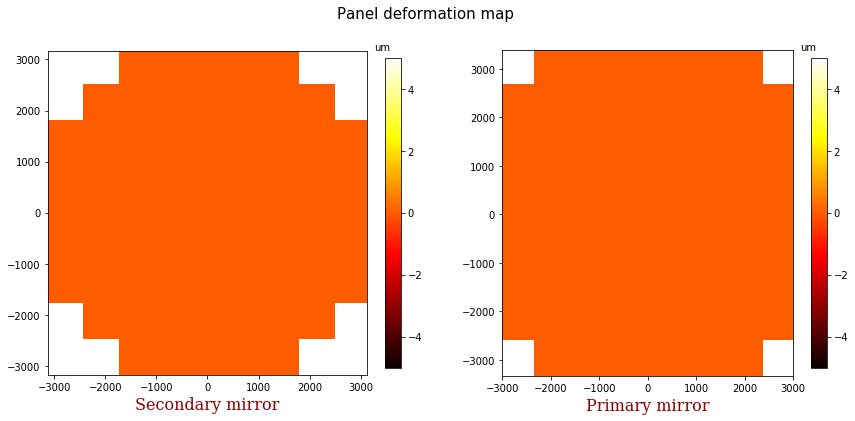

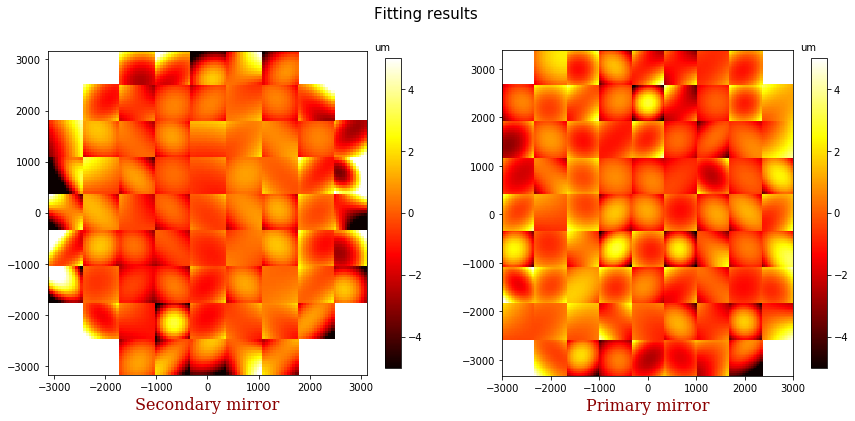

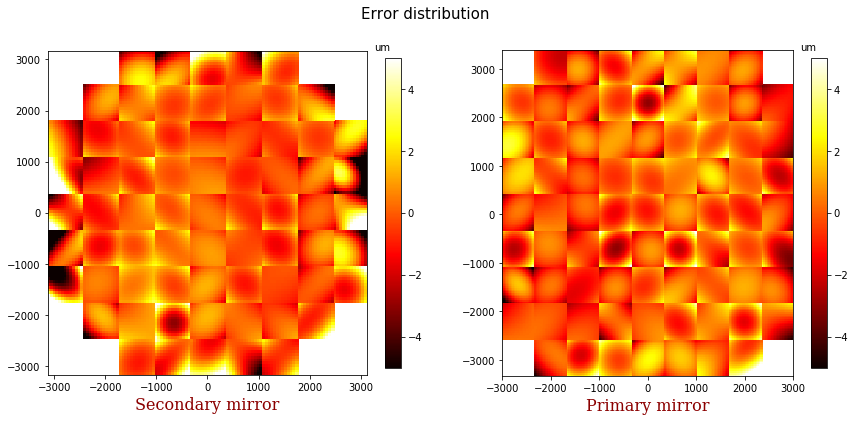

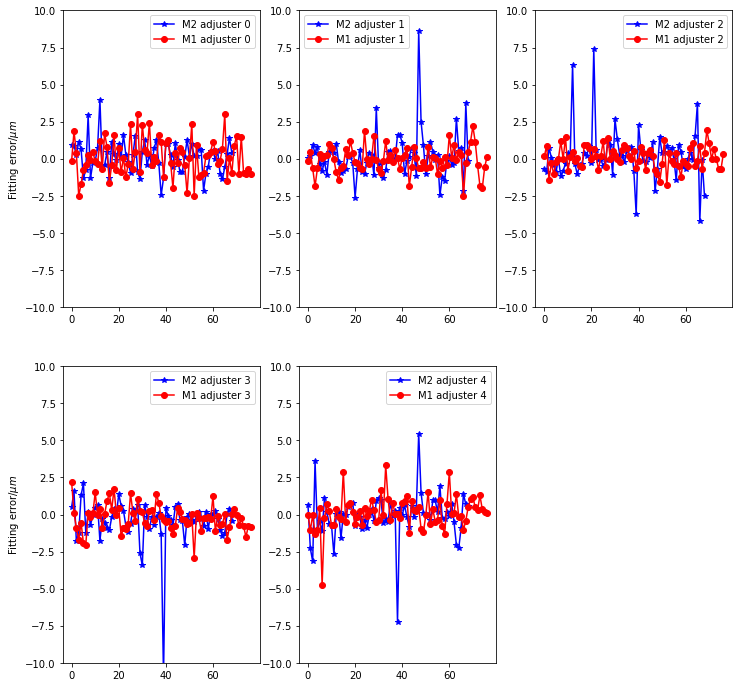

 M2 error: 1.7522941180507712 um
 M1 error 1.1379478172326072 um


In [2]:
'''
results plots
'''
filename='output/inference/'
#file_input='input_beams/measured_beam_maps_51/panel_error_296GHz.txt'
file_input='input_beams/measured_beam_maps_51/adjuster_zeros.txt'
name='1';
error_plots(file_input,filename+'results3.txt',name,inputrms=5,outputrms=5,scale=10)

In [ ]:
# 2.define the function used in least-square fitting loops;

'''
includes the large-scale parameters
'''
def inference(Lambda_00,Lambda_10,Lambda_01,Lambda_20,Lambda_02,measuredbeams,SNR=70):
    '''
    1. Lambda_00,Lambda_01,Lambda_10,Lambda_20,Lambda_02, parameters used to compress the degeneracy
    in large scale, which is the intrinsic degeneracy of the two-mirror system;
    2. measuredbeam, the input measured data;
    3. noise added to the 
    '''
    ''' get the locations of the adjusters'''
    x2=T.tensor(ad2_x).to(DEVICE0);
    y2=T.tensor(ad2_y).to(DEVICE0);
    x1=T.tensor(ad1_x).to(DEVICE0);
    y1=T.tensor(ad1_y).to(DEVICE0);
    '''read the measured beams'''
    test=np.genfromtxt(measuredbeams,delimiter=',');
    test=T.tensor(test).to(DEVICE0);
    test=correctphase(test)

    def fitfuc(parameters):
        '''input parameters put to tensor type'''
        Params=T.tensor(parameters,requires_grad=True);
        '''CPU OR GPU'''
        parameters=Params.to(DEVICE0)
        
        '''adjusters'''
        adjusters=parameters[0:5*(69+77)];
        '''large scale error in amplitude'''
        paraA=parameters[5*(69+77):5*(69+77)+6*4];
        '''large scale error in phase term (pointing error, curvature erorr)'''
        paraP=parameters[5*(69+77)+6*4:];
        '''forward calculation'''
        
        Data=forward_func(adjusters,paraA,paraP);
        Data=correctphase(Data)
        '''residual between simulation and measurement'''
        r0=((Data-test)**2).sum();
        
        # consider the lagrange factors
        S2=adjusters[0:5*69];
        S1=adjusters[5*69:];        
        #Z_00=T.abs((S1).sum())+T.abs((S2).sum()); # compress piston error in large scale;
        #Z_10=T.abs((x2*S2).sum())+T.abs((x1*S1).sum()) # compress slope error in x
        #Z_01=T.abs((y2*S2).sum())+T.abs((y1*S1).sum());# slope error in y
        #Z_20=T.abs((S2*x2**2).sum())+T.abs((S1*(x1**2)).sum()); #  curvature error;
        #Z_02=T.abs((S2*y2**2).sum())+T.abs((S1*(y1**2)).sum()); 
        #r=r0+Lambda_00*Z_00+Lambda_10*Z_10+Lambda_01*Z_01+Lambda_20*Z_20+Lambda_02*Z_02;
        
        Z_00=T.abs((S1).sum())+T.abs((S2).sum()); # compress piston error in large scale;
        Z_10=(S1**2).mean()+(S2**2).mean();
        Z_20=T.abs((S2*x2**2).sum())+T.abs((S1*(x1**2)).sum()); #  curvature error;
        Z_02=T.abs((S2*y2**2).sum())+T.abs((S1*(y1**2)).sum());
        r=r0+Lambda_00*Z_00+Lambda_10*Z_10+Lambda_20*Z_20+Lambda_02*Z_02;
        #print(Z_00.item(),Z_10.item(),Z_01.item(),Z_20.item(),Z_02.item(),Z_11.item(),Z_22.item());
        print(Z_00.item(),Z_10.item(),Z_20.item(),Z_02.item());
        
        r=r.sum();
        r.backward()
        print(r.item())
    
        return r.data.cpu().numpy(),Params.grad.data.cpu().numpy();
    
    '''initial input parameters'''
    ad=np.zeros(5*146+(6+5)*4); 
    ad[5*146]=1;ad[5*146+6*1]=1;
    ad[5*146+6*2]=1;ad[5*146+6*3]=1;
    
    start=time.perf_counter();
    results=scipy.optimize.minimize(fitfuc,ad,method="BFGS",jac=True,tol=1e-4);
    elapsed =(time.perf_counter()-start);
    print('time used:',elapsed);
    
    return results;

'''
start the fitting process;
'''
measuredbeams='input_beams/measured_beam_maps_51_actuallPanel/GRASP_296GHz_51_51_panel_quality_no_adjuster_err.txt'      
results=inference(0*10**(-2),0*10**(-1),0*10**(-2),0*10**(-2),0*10**(-2),measuredbeams);
'''
save data
'''
filename='output/inference/'
if not os.path.exists(filename):
    os.makedirs(filename);

np.savetxt(filename+'results4'+'.txt',results.x)

In [ ]:
'''
results plots
'''
filename='output/inference/'
#file_input='input_beams/measured_beam_maps_51/panel_error_296GHz.txt'
file_input='input_beams/measured_beam_maps_51/adjuster_zeros.txt'
name='1';
error_plots(file_input,filename+'results4.txt',name,inputrms=10,outputrms=10,scale=10)

In [ ]:
# 2.define the function used in least-square fitting loops;

'''
includes the large-scale parameters
'''
def inference(Lambda_00,Lambda_10,Lambda_01,Lambda_20,Lambda_02,measuredbeams,SNR=70):
    '''
    1. Lambda_00,Lambda_01,Lambda_10,Lambda_20,Lambda_02, parameters used to compress the degeneracy
    in large scale, which is the intrinsic degeneracy of the two-mirror system;
    2. measuredbeam, the input measured data;
    3. noise added to the 
    '''
    ''' get the locations of the adjusters'''
    x2=T.tensor(ad2_x).to(DEVICE0);
    y2=T.tensor(ad2_y).to(DEVICE0);
    x1=T.tensor(ad1_x).to(DEVICE0);
    y1=T.tensor(ad1_y).to(DEVICE0);
    '''read the measured beams'''
    test=np.genfromtxt(measuredbeams,delimiter=',');
    test=T.tensor(test).to(DEVICE0);
    test=correctphase(test)

    def fitfuc(parameters):
        '''input parameters put to tensor type'''
        Params=T.tensor(parameters,requires_grad=True);
        '''CPU OR GPU'''
        parameters=Params.to(DEVICE0)
        
        '''adjusters'''
        adjusters=parameters[0:5*(69+77)];
        '''large scale error in amplitude'''
        paraA=parameters[5*(69+77):5*(69+77)+6*4];
        '''large scale error in phase term (pointing error, curvature erorr)'''
        paraP=parameters[5*(69+77)+6*4:];
        '''forward calculation'''
        
        Data=forward_func(adjusters,paraA,paraP);
        Data=correctphase(Data)
        '''residual between simulation and measurement'''
        r0=((Data-test)**2).sum();
        
        # consider the lagrange factors
        S2=adjusters[0:5*69];
        S1=adjusters[5*69:];        
        #Z_00=T.abs((S1).sum())+T.abs((S2).sum()); # compress piston error in large scale;
        #Z_10=T.abs((x2*S2).sum())+T.abs((x1*S1).sum()) # compress slope error in x
        #Z_01=T.abs((y2*S2).sum())+T.abs((y1*S1).sum());# slope error in y
        #Z_20=T.abs((S2*x2**2).sum())+T.abs((S1*(x1**2)).sum()); #  curvature error;
        #Z_02=T.abs((S2*y2**2).sum())+T.abs((S1*(y1**2)).sum()); 
        #r=r0+Lambda_00*Z_00+Lambda_10*Z_10+Lambda_01*Z_01+Lambda_20*Z_20+Lambda_02*Z_02;
        
        Z_00=T.abs((S1).sum())+T.abs((S2).sum()); # compress piston error in large scale;
        Z_10=(S1**2).mean()+(S2**2).mean();
        Z_20=T.abs((S2*x2**2).sum())+T.abs((S1*(x1**2)).sum()); #  curvature error;
        Z_02=T.abs((S2*y2**2).sum())+T.abs((S1*(y1**2)).sum());
        r=r0+Lambda_00*Z_00+Lambda_10*Z_10+Lambda_20*Z_20+Lambda_02*Z_02;
        #print(Z_00.item(),Z_10.item(),Z_01.item(),Z_20.item(),Z_02.item(),Z_11.item(),Z_22.item());
        print(Z_00.item(),Z_10.item(),Z_20.item(),Z_02.item());
        
        r=r.sum();
        r.backward()
        print(r.item())
    
        return r.data.cpu().numpy(),Params.grad.data.cpu().numpy();
    
    '''initial input parameters'''
    ad=np.zeros(5*146+(6+5)*4); 
    ad[5*146]=1;ad[5*146+6*1]=1;
    ad[5*146+6*2]=1;ad[5*146+6*3]=1;
    
    start=time.perf_counter();
    results=scipy.optimize.minimize(fitfuc,ad,method="BFGS",jac=True,tol=1e-4);
    elapsed =(time.perf_counter()-start);
    print('time used:',elapsed);
    
    return results;

'''
start the fitting process;
'''
measuredbeams='input_beams/measured_beam_maps/GRASP_296GHz_51_51_panel_quality_no_adjuster_err.txt'      
results=inference(0*10**(-2),0*10**(-1),0*10**(-2),0*10**(-2),0*10**(-2),measuredbeams);
'''
save data
'''
filename='output/inference/'
if not os.path.exists(filename):
    os.makedirs(filename);

np.savetxt(filename+'results0'+'.txt',results.x)